# Description

In this notebook, I will train the CNN model in the FL system. During the training, I will prune the filters of the CNN.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.random.set_seed(42)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:  tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e: print(e)

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize

from sklearn.model_selection import train_test_split

from config import *
from utils.read_data_utils import *
from utils.model_utils import *
from utils.pruning_utils import *

2024-04-12 12:44:14.582666: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 12:44:14.582684: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 12:44:14.582718: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. Dataset

## 1.1. Load dataset

In [3]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In [4]:
num_clients = len(emnist_train.client_ids)
print(f"Number of clients: {num_clients}")

list_num_samples = []
for idx_client in range(num_clients):
    num_samples = len(list(emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[idx_client])))
    list_num_samples.append(num_samples)
list_num_samples = np.array(list_num_samples)

print(f"Total number of samples in training set: {list_num_samples.sum()}")
print(f"Average number of samples per client: {list_num_samples.mean()}")

Number of clients: 3383
Total number of samples in training set: 341873
Average number of samples per client: 101.0561631687851


## 1.2. Prepare training dataset

In [5]:
list_clients_data = Create_Clients_Data(emnist_train, DATASET_NAME)
print(f"Number of user: {len(list_clients_data)}")

Number of user: 3383


Number of client: 3383


/home/necphy/miniconda3/envs/fl_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/necphy/miniconda3/envs/fl_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


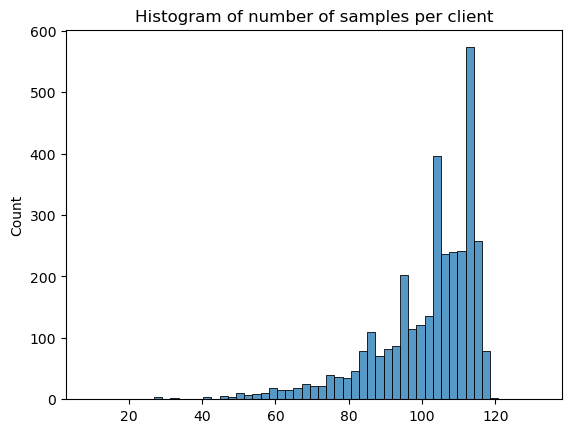

In [6]:
list_num_samples = []

for client_data in list_clients_data:
    list_X = client_data['list_X']
    list_num_samples.append(len(list_X))

print(f"Number of client: {len(list_num_samples)}")
plt.title("Histogram of number of samples per client")
sns.histplot(list_num_samples)
plt.show();

Shape of image: (28, 28, 1)
Client name= f0001_41
Label = [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


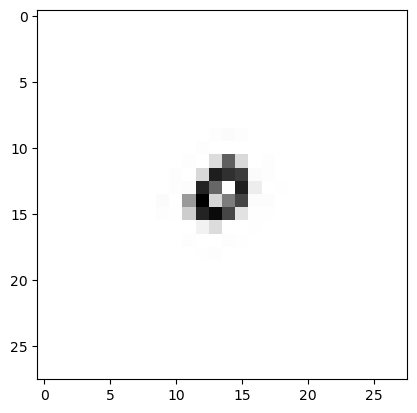

In [7]:
idx_client = idx_sample = np.random.randint(0, 50)

client_data = list_clients_data[idx_client]

client_name = client_data['client_name']
list_X = client_data['list_X']
list_y = client_data['list_y']

X = list_X[idx_sample]
print(f"Shape of image: {X.shape}")
y = list_y[idx_sample]

print(f"Client name= {client_name}")
print(f"Label = {y}")
plt.imshow(X, cmap='gray')
plt.show();

## 1.3. Prepare val - test dataset

In [9]:
list_data_test = Create_Clients_Data(emnist_test)

X_test = []
y_test = []
for data_test in list_data_test:
    X_test.append(data_test['list_X'])
    y_test.append(data_test['list_y'])
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f"Shape of X val: {X_val.shape}")
print(f"Shape of y val: {y_val.shape}")

print(f"Shape of X test: {X_test.shape}")
print(f"Shape of y test: {y_test.shape}")

Shape of X val: (20416, 28, 28, 1)
Shape of y val: (20416, 10)
Shape of X test: (20416, 28, 28, 1)
Shape of y test: (20416, 10)


# 2. Training FL 

In [23]:
keras.backend.clear_session()
global_model = Define_Simple_CNN_Model(input_shape=INPUT_SHAPE, output_shape=OUPUT_SHAPE,\
                            list_number_kernel=LIST_NUMBER_KERNEL, kernel_size=KERNEL_SIZE, dropout_rate=DROPOUT_RATE,\
                            model_name="global_model")
global_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics = METRICS)
# global_model.summary()

In [24]:
client_model = keras.models.clone_model(global_model)    
client_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

In [25]:
def prune_model(model, optimizer, loss_func, metrics, std_threshold=3.0):
    """
    This function take input as model and perform model pruning to return the pruned filters CNN model.

    * Parameters:
        model (keras model): input model.
        optimizer (keras optimizer).
        loss_func (keras loss function).
        metrics (keras metrics)
        std_threshold (integer): threshold to prune filters.

    * Return:
        model (keras model) -- the pruned filters model.
    """

    global IS_STILL_PRUNE
    global PRUNE_PATIENCE
    before_prune_params = model.count_params()

    list_number_kernel = []
    for layer in model.layers:
        if isinstance(layer, Conv2D) and layer.name != 'classifier':
            weights = layer.get_weights()[0]
            pruned_kernel = Apply_Pruning_Filter(weights, std_threshold)
            pruned_number_kernel = pruned_kernel.shape[-1]

            if pruned_number_kernel <= 0:
                pruned_number_kernel = 1
            list_number_kernel.append(pruned_number_kernel)

    new_model = Define_Simple_CNN_Model(input_shape=model.input_shape[1:], output_shape=model.output_shape[1], list_number_kernel=list_number_kernel)
    new_model_params = new_model.count_params()

    if before_prune_params > new_model_params:
        PRUNE_PATIENCE = 0
        print(f"--- [INFO] This round PRUNE filter ---")
        new_model.compile(optimizer=optimizer, loss=loss_func, metrics=metrics)
        return new_model
    else:
        PRUNE_PATIENCE += 1
        print(f"--- [INFO] This round NOT prune filter ---")
        if PRUNE_PATIENCE >= MAX_PRUNE_PATIENCE:
            IS_STILL_PRUNE = False
            print(f"===== [INFO] Stop prune here! =====")
            print(f"Final params: {before_prune_params}")
        return model


In [26]:
NUM_CLIENTS = num_clients
list_val_acc = []
list_val_loss = []
list_model_params = []


for idx_round in range(NUM_ROUNDS):
    print("\n [INFO] Round {}".format(idx_round))

    if (idx_round > MAX_PRUNED_ROUND) and (IS_STILL_PRUNE == True):
        IS_STILL_PRUNE = False
        print(f"===== [INFO] Stop prune here! =====")
        print(f"Final params: {global_model.count_params()}")

    if (0 < idx_round) and (IS_STILL_PRUNE == True):
        global_model = prune_model(global_model, optimizer=OPTIMIZER, loss_func=LOSS, metrics=METRICS, std_threshold=STD_THRESHOLD_PRUNE)

        client_model = keras.models.clone_model(global_model)    
        client_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

    # Select random subset of clients
    selected_percent_client = np.random.uniform(0.0, MAX_SELECTED_PERCENT_CLIENT)
    num_selected_clients = max(int(NUM_CLIENTS * selected_percent_client), 1)
    selected_clients_data = random.sample(list_clients_data, num_selected_clients)

    # Loop through selected client
    list_client_model_weight = []
    list_client_scales = []
    for selectd_client_data in selected_clients_data:      
        client_model.set_weights(global_model.get_weights())  # Clone global model

        list_X = selectd_client_data['list_X']
        list_y = selectd_client_data['list_y']
        client_model.fit(list_X, list_y, epochs=LOCAL_EPOCHS, batch_size=LOCAL_BATCH_SIZE, verbose=0, validation_split=0.05)

        list_client_model_weight.append(client_model.get_weights())    # store local weight for update global model later.
        list_client_scales.append(len(list_X))
    
    # Calculate scale of each client
    list_client_scales = np.array(list_client_scales)
    list_client_scales = list_client_scales / list_client_scales.sum()

    # Update the global model weights
    avg_weights = FedAvg(global_model, list_client_model_weight, list_client_scales)
    global_model.set_weights(avg_weights)

    # Evaluate model on validation data
    val_loss, val_acc = global_model.evaluate(X_val, y_val, verbose=0)
    print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')
    list_val_acc.append(val_acc)
    list_val_loss.append(val_loss)


 [INFO] Round 0
Val loss: 2.2576775550842285, Val accuracy: 0.2901155948638916

 [INFO] Round 1
--- [INFO] This round PRUNE filter ---
Val loss: 2.271605968475342, Val accuracy: 0.14895179867744446

 [INFO] Round 2
--- [INFO] This round PRUNE filter ---
Val loss: 2.30131459236145, Val accuracy: 0.13842085003852844

 [INFO] Round 3
--- [INFO] This round PRUNE filter ---
Val loss: 2.2837893962860107, Val accuracy: 0.11280368268489838

 [INFO] Round 4
--- [INFO] This round PRUNE filter ---
Val loss: 2.291346549987793, Val accuracy: 0.09468064457178116

 [INFO] Round 5
--- [INFO] This round PRUNE filter ---
Val loss: 2.277313709259033, Val accuracy: 0.14278016984462738

 [INFO] Round 6
--- [INFO] This round PRUNE filter ---
Val loss: 2.289297580718994, Val accuracy: 0.15144984424114227

 [INFO] Round 7
--- [INFO] This round PRUNE filter ---
Val loss: 2.2869930267333984, Val accuracy: 0.23359130322933197

 [INFO] Round 8
--- [INFO] This round PRUNE filter ---
Val loss: 2.299830198287964, V

# 3. Evaluation

In [27]:
# X_test = np.array([resize(image, (IMAGE_DIMENSION, IMAGE_DIMENSION)) for image in X_test])
print(f"Shape of X test: {X_test.shape}")
print(f"Shape of y test: {y_test.shape}")

Shape of X test: (20416, 28, 28, 1)
Shape of y test: (20416, 10)


In [28]:
# Evaluate model on testing data
val_loss, val_acc = global_model.evaluate(X_test, y_test, verbose=0)
print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')

Val loss: 0.1259092092514038, Val accuracy: 0.9610599279403687
